In [5]:
%pip install seafreeze
%pip install parquet
%pip install pyarrow
%pip install pandas
%pip install pycaret 
%pip install scikit-learn 
%pip install scipy==1.11.4
import numpy as np
from seafreeze import seafreeze as sf
import os as os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pycaret.regression import *
from sklearn import preprocessing
import matplotlib.pyplot as plt


  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.0 requires scipy<=1.11.4,>=1.6.1, but you have scipy 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached scipy-1.11.4-cp39-cp39-macosx_12_0_arm64.whl (29.7 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency 

In [24]:
# Load data from parquet file and subset to below 500 MPa

props = ('G', 'S', 'U', 'H', 'A', 'rho', 'Cp') #, 'Kt', 'Kp', 'Ks', 'alpha', 'vel', 'mus', 'muw', 'Vm', 'Cpm', 'Cpa', 'Va', 'Vex', 'phi', 'aw', 'gam', 'Gex')

# Define directory for G data  
dirG = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/data/ai_ready/', 'G')
os.makedirs(dirG, exist_ok=True)
dfG = pq.read_table(os.path.join(dirG, 'NaCl_G.parquet')).to_pandas()

# Filter data for pressures below 0.5 GPa (500 MPa)
dfG = dfG[dfG['P_Mpa'] < 500]

# Initialize data_j with headers
data_j = pd.DataFrame(columns=['P_Mpa', 'T_K', 'm_molkg'] + list(props))

# Add G data to data_j
data_j['P_Mpa'] = dfG['P_Mpa']
data_j['T_K'] = dfG['T_K']
data_j['m_molkg'] = dfG['m_molkg']

for j in props: 
    dir_ready = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/data/ai_ready/', j)
    os.makedirs(dir_ready, exist_ok=True)
    df = pq.read_table(os.path.join(dir_ready, f'NaCl_{j}.parquet')).to_pandas()
    
    # Filter data for pressures below 2 GPa (2000 MPa)
    df = df[df['P_Mpa'] < 2000]
    
    # Add property data to data_j
    data_j[f'{j}'] = df[f'{j}']

# Display the shape, first few rows of the structure to verify
print("Full DataFrame shape:", data_j.shape)
print(data_j.head())

Full DataFrame shape: (939401, 10)
   P_Mpa    T_K  m_molkg             G           S              U  \
0    0.1  240.0      0.0  -8926.550362 -582.447446 -148816.097810   
1   10.1  240.0      0.0   1243.813309 -565.772512 -144768.598346   
2   20.1  240.0      0.0  11326.998932 -552.246594 -141395.802828   
3   30.1  240.0      0.0  21328.899131 -541.372011 -138589.316172   
4   40.1  240.0      0.0  31254.927198 -532.721316 -136256.214314   

               H            A          rho           Cp  
0 -148713.937389 -9028.710783   978.852659  5300.978960  
1 -134541.589582 -8983.195455   987.581045  4987.894841  
2 -121212.183512 -8856.620385   995.857070  4744.177162  
3 -108600.383619 -8660.033422  1003.703615  4552.559071  
4  -96598.188562 -8403.098554  1011.144636  4399.396981  


,Description,Value
0,Session id,123
1,Target,G
2,Target type,Regression
3,Original data shape,"(939401, 4)"
4,Transformed data shape,"(939401, 4)"
5,Transformed train set shape,"(657580, 4)"
6,Transformed test set shape,"(281821, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.0044,0.0000,0.0064,1.0000,0.0040,0.0395,0.2890
et,Extra Trees Regressor,0.0007,0.0000,0.0015,1.0000,0.0009,0.0057,25.5470
rf,Random Forest Regressor,0.0015,0.0000,0.0024,1.0000,0.0015,0.0128,20.8190
lightgbm,Light Gradient Boosting Machine,0.0085,0.0001,0.0111,0.9999,0.0068,0.0822,0.8430
knn,K Neighbors Regressor,0.0073,0.0001,0.0090,0.9999,0.0054,0.0620,0.1740
gbr,Gradient Boosting Regressor,0.0175,0.0005,0.0220,0.9995,0.0137,0.1626,6.7760
lar,Least Angle Regression,0.0920,0.0129,0.1136,0.9871,0.0623,0.7261,0.0390
br,Bayesian Ridge,0.0920,0.0129,0.1136,0.9871,0.0623,0.7262,0.0400
ridge,Ridge Regression,0.0920,0.0129,0.1136,0.9871,0.0623,0.7261,0.0370
lr,Linear Regression,0.0920,0.0129,0.1136,0.9871,0.0623,0.7262,0.4330


DecisionTreeRegressor(random_state=123)


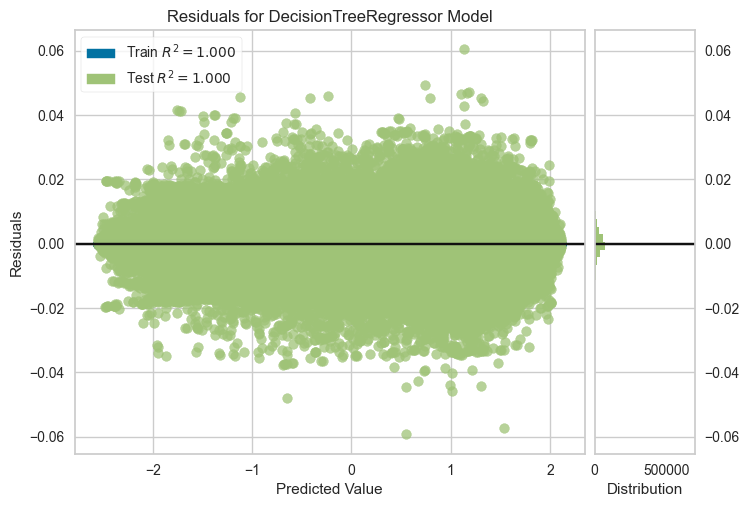

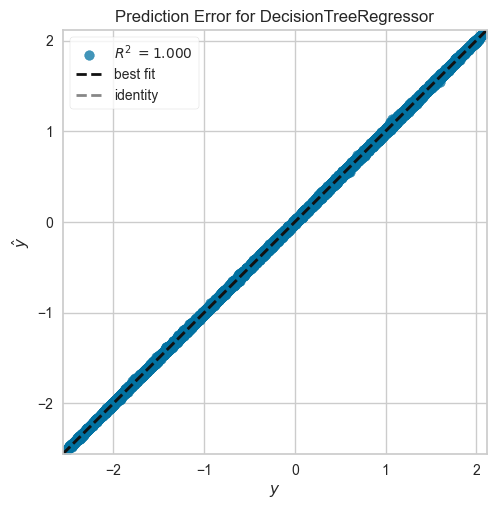

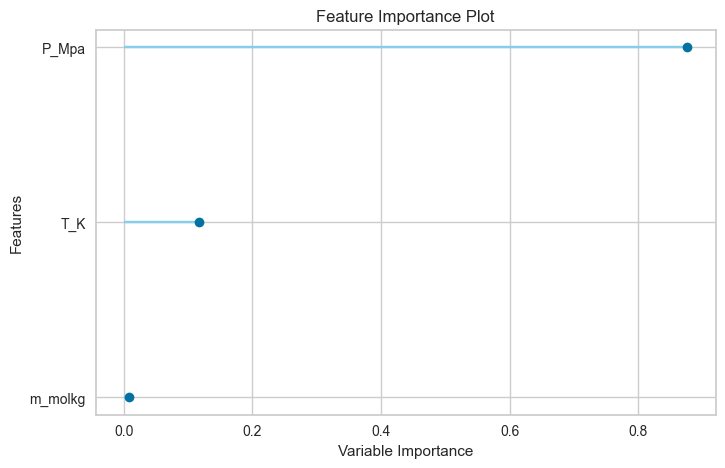

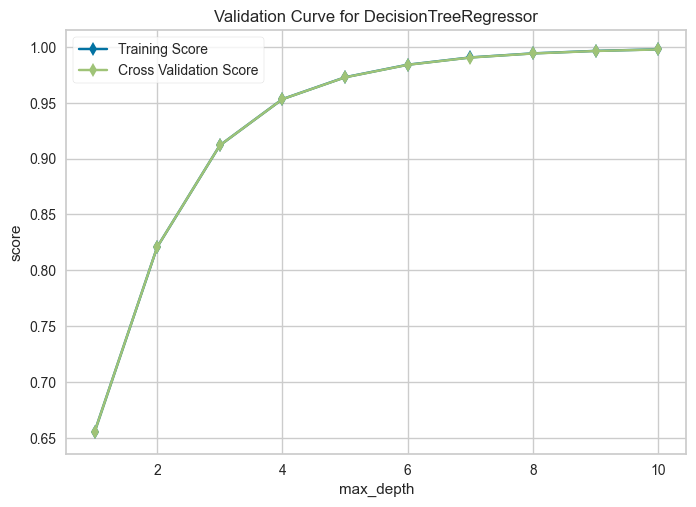

<Figure size 800x550 with 0 Axes>

In [32]:
X = data_j[['P_Mpa', 'T_K', 'm_molkg']]
y = data_j['G'].to_numpy().reshape(-1, 1) 

# Normalize the target variable (MSE looks awful without this)
scaler = preprocessing.StandardScaler().fit(y)
y = scaler.transform(y)
y = pd.DataFrame(y, columns=['G'])

# Combine features and target into a single DataFrame  
data_pycaret = pd.concat([X, y], axis=1)

regression_setup = setup(data=data_pycaret, target='G', session_id=123, normalize=True, use_gpu=False)
models()
best_model = compare_models()

print(best_model)

plot_model(best_model)
plot_model(best_model, plot = 'error')
plot_model(best_model, plot='feature')

plt.figure()
plot_model(best_model, plot=plot_type)
plt.savefig(os.path.join(figures_dir, f'{target}_{best_model}_{plot_type}.png'))
plt.show()


Looks pretty good. The best model is decision tree regressor, which recursively minimizes MSE to split the data into subsets based on the feature that results in the best split. The recursion ends when a given stopping criterion is met.

Now I want to do this again for all of my target features with normalization; I will loop through them and save both the models and several representative figures for each one.

,Description,Value
0,Session id,42
1,Target,Cp
2,Target type,Regression
3,Original data shape,"(939401, 4)"
4,Transformed data shape,"(939401, 4)"
5,Transformed train set shape,"(657580, 4)"
6,Transformed test set shape,"(281821, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0021,0.0000,0.0053,1.0000,0.0023,0.0223,21.0660
et,Extra Trees Regressor,0.0010,0.0000,0.0039,1.0000,0.0014,0.0109,22.5580
dt,Decision Tree Regressor,0.0053,0.0001,0.0105,0.9999,0.0050,0.0514,0.3610
lightgbm,Light Gradient Boosting Machine,0.0180,0.0006,0.0241,0.9994,0.0143,0.2082,0.9320
gbr,Gradient Boosting Regressor,0.0468,0.0043,0.0658,0.9957,0.0368,0.3928,7.8870
knn,K Neighbors Regressor,0.0524,0.0082,0.0908,0.9918,0.0409,0.3465,0.2320
lar,Least Angle Regression,0.1950,0.0738,0.2716,0.9263,0.1372,2.0241,0.0340
br,Bayesian Ridge,0.1951,0.0738,0.2716,0.9263,0.1372,2.0242,0.0430
ridge,Ridge Regression,0.1950,0.0738,0.2716,0.9263,0.1372,2.0241,0.0380
lr,Linear Regression,0.1951,0.0738,0.2716,0.9263,0.1372,2.0242,0.3510


Transformation Pipeline and Model Successfully Saved


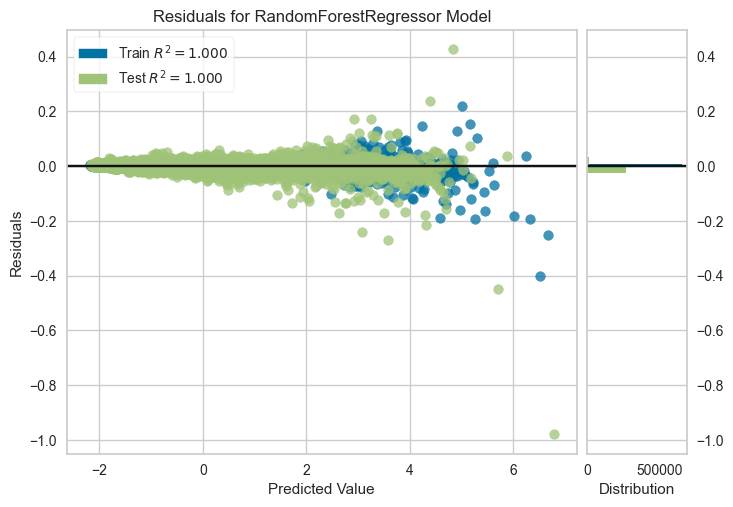

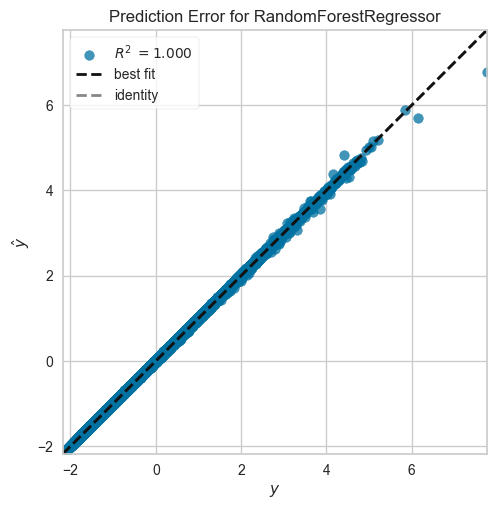

Failed to save Cp learning


Failed to save Cp vc


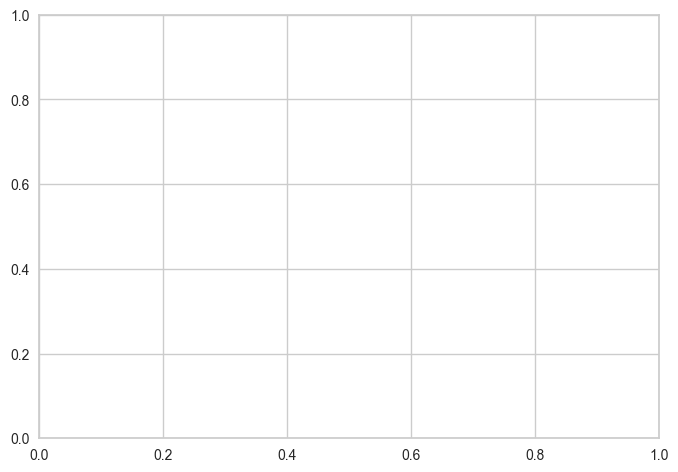

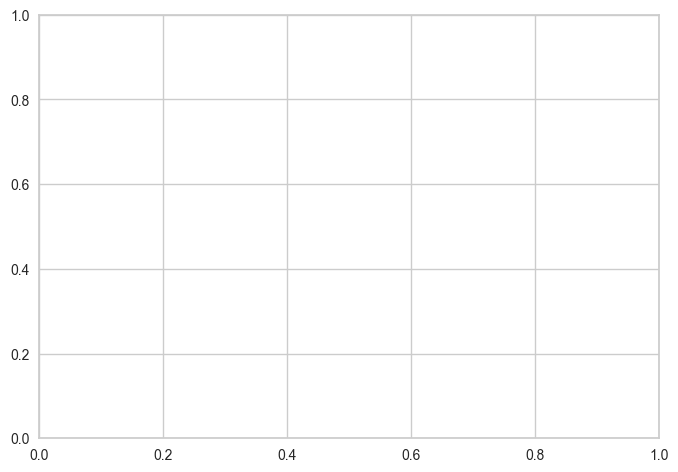

In [31]:
# List of target features 
target_features = ['S', 'U', 'H', 'A', 'rho', 'Cp']

# Directory to save figures
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)

# Loop through each target feature
for target in target_features:
    # Normalize the target variable (MSE looks awful without this)
    y = data_j[target].to_numpy().reshape(-1, 1) 
    scaler = preprocessing.StandardScaler().fit(y)
    y = scaler.transform(y)
    y = pd.DataFrame(y, columns=[target])

    # Combine features and target into a single DataFrame for PyCaret
    data_pycaret = pd.concat([X, y], axis=1)
    
    # Initialize the PyCaret regression setup
    regression_setup = setup(data=data_pycaret, target=target, session_id=42)
    
    # Create and compare models to find the best one
    best_model = compare_models()
    print(best_model)
    
    # Save the best model
    save_model(best_model, os.path.join(figures_dir, f'best_model_{target}'))
    
    # Save figures
    for plot_type in ['residuals', 'error', 'learning', 'vc']:
        try:
            plt.figure()
            plot_model(best_model, plot=plot_type)
            plt.savefig(os.path.join(figures_dir, f'{target}_{best_model}_{plot_type}.png'))
            plt.show()
        except:
            print(f"Failed to save {target} {plot_type}")